In [17]:
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score
from sklearn.preprocessing import LabelEncoder

import pandas as pd

In [18]:
data = pd.read_csv('cars.csv', sep=';')
data.drop(['Tiempo', 'EDAD_COCHE'],axis=1, inplace=True)
data.head()

,CODE,PRODUCTO,TIPO_CARROCERIA,COMBUSTIBLE,Potencia_,TRANS,FORMA_PAGO,ESTADO_CIVIL,GENERO,OcupaciOn,...,Campanna3,Zona _Renta,REV_Garantia,Averia_grave,QUEJA_CAC,COSTE_VENTA,km_anno,Mas_1_coche,Revisiones,Edad Cliente
0,CLI1,A,TIPO1,FUEL 1,Baja,M,Contado,CASADO,M,Empresa,...,NO,Medio-Bajo,NO DATA,Averia muy grave,SI,2892,0,0,2,18
1,CLI2,A,TIPO1,FUEL 1,Baja,M,Contado,CASADO,F,Empresa,...,NO,Medio-Bajo,SI,No,NO,1376,7187,0,2,53
2,CLI3,A,TIPO1,FUEL 1,Baja,M,Otros,CASADO,M,Empresa,...,NO,Medio,NO DATA,No,NO,1376,0,1,4,21
3,CLI4,A,TIPO1,FUEL 1,Baja,M,Financiera Marca,CASADO,F,Empresa,...,NO,Medio,SI,Averia muy grave,SI,2015,7256,1,4,48
4,CLI5,A,TIPO1,FUEL 1,Baja,M,Financiera Marca,CASADO,F,Funcionario,...,SI,Alto,NO DATA,No,NO,1818,0,1,3,21


## Columnas categóricas a columnas numéricas

In [27]:
# Identificar las columnas categóricas
categorical_columns = data.select_dtypes(include=['object']).columns

# Usar LabelEncoder para convertir las columnas categóricas en numéricas
label_encoders = {}
for column in categorical_columns:
    label_encoders[column] = LabelEncoder()
    data[column] = label_encoders[column].fit_transform(data[column].astype(str))

In [19]:
# Identificar las columnas categóricas
categorical_columns = ['CODE', 'PRODUCTO', 'TIPO_CARROCERIA', 'COMBUSTIBLE', 'Potencia_', 'TRANS', 'FORMA_PAGO',
                       'ESTADO_CIVIL', 'GENERO', 'OcupaciOn', 'PROVINCIA', 'Campanna1', 'Campanna2', 'Campanna3',
                       'Zona _Renta', 'REV_Garantia', 'Averia_grave', 'QUEJA_CAC']

# Aplicar LabelEncoder a las columnas categóricas
label_encoders = {}
for column in categorical_columns:
    label_encoders[column] = LabelEncoder()
    data[column] = label_encoders[column].fit_transform(data[column].astype(str))

# Asegúrate de que ahora todas las columnas sean numéricas
print(data.dtypes)

CODE               int32
PRODUCTO           int32
TIPO_CARROCERIA    int32
COMBUSTIBLE        int32
Potencia_          int32
TRANS              int32
FORMA_PAGO         int32
ESTADO_CIVIL       int32
GENERO             int32
OcupaciOn          int32
PROVINCIA          int32
Campanna1          int32
Campanna2          int32
Campanna3          int32
Zona _Renta        int32
REV_Garantia       int32
Averia_grave       int32
QUEJA_CAC          int32
COSTE_VENTA        int64
km_anno            int64
Mas_1_coche        int64
Revisiones         int64
Edad Cliente       int64
dtype: object


In [20]:
# Separar las características (X) de la variable objetivo (y)
X = data.drop('Mas_1_coche', axis=1)
y = data['Mas_1_coche']

# Dividir los datos en conjunto de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Crear el modelo XGBoost
model_xgb = xgb.XGBClassifier(
    n_estimators=100,
    learning_rate=0.1,
    max_depth=6,
    random_state=42,
    use_label_encoder=False
)

# Entrenar el modelo
model_xgb.fit(X_train, y_train)

# Realizar predicciones y evaluar el rendimiento
y_pred_xgb = model_xgb.predict(X_test)
accuracy_xgb = accuracy_score(y_test, y_pred_xgb)
report_xgb = classification_report(y_test, y_pred_xgb)

print(f"Accuracy: {accuracy_xgb}")
print("Classification Report:\n", report_xgb)

c:\Users\mglez\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [16:19:59] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Accuracy: 0.872093023255814
Classification Report:
               precision    recall  f1-score   support

           0       0.90      0.93      0.91      8338
           1       0.80      0.73      0.76      3272

    accuracy                           0.87     11610
   macro avg       0.85      0.83      0.84     11610
weighted avg       0.87      0.87      0.87     11610



## Procesamos el nuevo conjunto de datos y miramos las predicciones

In [25]:
ndf = pd.read_csv('cars_input.csv', delimiter=';')

In [26]:
# Preprocesar el nuevo conjunto de datos
for column in categorical_columns:
    if column in ndf.columns:
        # Detectar nuevas categorías
        categorias_vistas = set(label_encoders[column].classes_)
        categorias_nuevas = set(ndf[column].astype(str).unique()) - categorias_vistas
        
        if categorias_nuevas:
            print(f"Column '{column}' contains new categories: {categorias_nuevas}")

            # Asignar una categoría especial "Desconocido" para las nuevas categorías
            ndf[column] = ndf[column].apply(lambda x: x if x in categorias_vistas else 'Desconocido')
            
            # Añadir la categoría "Desconocido" a las clases del LabelEncoder
            label_encoders[column].classes_ = np.append(label_encoders[column].classes_, 'Desconocido')

        # Transformar la columna categórica usando el LabelEncoder entrenado
        ndf[column] = label_encoders[column].transform(ndf[column].astype(str))

Column 'CODE' contains new categories: {'CLIN10414', 'CLIN21509', 'CLIN14926', 'CLIN1702', 'CLIN1388', 'CLIN8008', 'CLIN18321', 'CLIN12672', 'CLIN11116', 'CLIN9918', 'CLIN8630', 'CLIN20926', 'CLIN7066', 'CLIN16879', 'CLIN2402', 'CLIN2868', 'CLIN19510', 'CLIN21232', 'CLIN5047', 'CLIN5496', 'CLIN23086', 'CLIN20809', 'CLIN11943', 'CLIN2753', 'CLIN3284', 'CLIN21879', 'CLIN17723', 'CLIN1057', 'CLIN18610', 'CLIN7192', 'CLIN19978', 'CLIN19449', 'CLIN9404', 'CLIN8849', 'CLIN6795', 'CLIN1723', 'CLIN19638', 'CLIN20268', 'CLIN13112', 'CLIN17228', 'CLIN16034', 'CLIN6473', 'CLIN14055', 'CLIN13623', 'CLIN12508', 'CLIN7286', 'CLIN18568', 'CLIN11975', 'CLIN15706', 'CLIN15757', 'CLIN2277', 'CLIN22152', 'CLIN6658', 'CLIN260', 'CLIN5141', 'CLIN7499', 'CLIN18040', 'CLIN14545', 'CLIN22524', 'CLIN409', 'CLIN6319', 'CLIN11561', 'CLIN3738', 'CLIN16463', 'CLIN13910', 'CLIN12913', 'CLIN8616', 'CLIN15862', 'CLIN14515', 'CLIN11976', 'CLIN10741', 'CLIN16254', 'CLIN14924', 'CLIN14781', 'CLIN21559', 'CLIN5009', 'CLI

NameError: name 'np' is not defined

## Verificar

## Curva ROC

In [21]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

In [22]:
# Obtener las probabilidades predichas para la clase positiva (Mas_1_coche == 1)
y_pred_prob = model_xgb.predict_proba(X_test)[:, 1]  # Probabilidad de la clase positiva


In [23]:
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
roc_auc = auc(fpr, tpr)

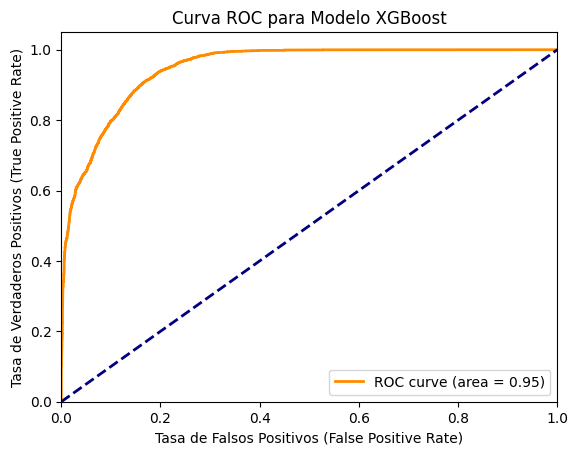

In [24]:
# Trazar la curva ROC
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')  # Línea diagonal (clasificación aleatoria)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Tasa de Falsos Positivos (False Positive Rate)')
plt.ylabel('Tasa de Verdaderos Positivos (True Positive Rate)')
plt.title('Curva ROC para Modelo XGBoost')
plt.legend(loc="lower right")
plt.show()